!pip install --upgrade scikit-learn

In [105]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path=os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **1. Import libraries**

In [187]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import joblib
import sklearn
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, QuantileTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import (
    r2_score, mean_absolute_error,
    mean_squared_error, root_mean_squared_error,
    explained_variance_score,median_absolute_error
)

In [107]:
!python --version

Python 3.10.13


In [108]:
sns.set_context("paper")

In [109]:
set_config(display="diagram")

## **2. EDA on diamonds dataset**
#### For EDA on this dataset, please check out this *[Kaggle Notebook](https://www.kaggle.com/code/nikendrashekhawat/diamonds-eda)* or *[Github Notebook](https://github.com/nikendrashekhawat/EDA-Kaggle-Notebooks/blob/1b8427b026b4c2dcab3e39196ed89f706a00df02/EDA_Diamonds.ipynb)*.

In [110]:
data = pd.read_csv(path, index_col=0)

In [111]:
df= data.copy()

In [112]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [113]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [114]:
df.duplicated().sum()

146

In [115]:
df = df.drop_duplicates()

In [116]:
df.to_csv('cleaned_data.csv')

In [117]:
X = df.drop('price', axis=1)
y = df['price']

In [118]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [119]:
y.head()

1    326
2    326
3    327
4    334
5    335
Name: price, dtype: int64

In [120]:
df.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [121]:
X['cut'].value_counts()

cut
Ideal        21488
Premium      13748
Very Good    12069
Good          4891
Fair          1598
Name: count, dtype: int64

In [122]:
X['clarity'].value_counts()

clarity
SI1     13032
VS2     12229
SI2      9150
VS1      8156
VVS2     5056
VVS1     3647
IF       1784
I1        740
Name: count, dtype: int64

In [123]:
X['color'].value_counts()

color
G    11262
E     9776
F     9520
H     8272
D     6755
I     5407
J     2802
Name: count, dtype: int64

## **3. Checking Correlation among features and target value**

In [124]:
corr = df.corr(numeric_only=True)

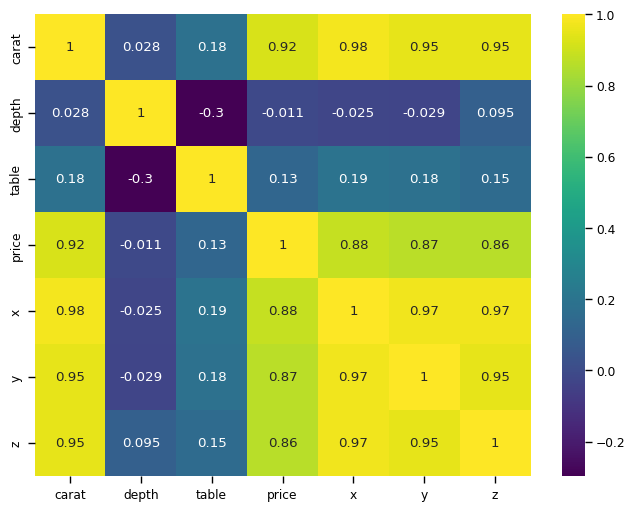

In [170]:
fig, axs = plt.subplots(figsize=(8,6))
_ = sns.heatmap(corr, cmap="viridis", annot=True)

## **4. Helper functions**

In [126]:
def get_estimator_name(estimator)-> str:
    name = ''
    if isinstance(estimator[-1], sklearn.base.RegressorMixin):
        name = estimator[-1].__class__.__name__
    if isinstance(estimator[-1], sklearn.compose.TransformedTargetRegressor):
        name = ("TransformedTarget_" + estimator[-1].regressor_.__class__.__name__)
    return name


def transformed_target(estimator=None) -> TransformedTargetRegressor:
    quantile = QuantileTransformer(output_distribution='normal')
    trans_target_reg = TransformedTargetRegressor(regressor=estimator, transformer=quantile)
    return trans_target_reg


def plot_ap(y_true, y_pred, title=None, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    y_true_min_val = np.min(y_true)
    y_true_max_val = np.max(y_true)
    scatter_kws = {'s': 20, 'alpha': 0.6, 'color': 'steelblue', 'edgecolor': 'face'}
    line_kws = {'color': 'red', 'linestyle': '--', 'linewidth':1.8, 'alpha': 0.8, 'label': 'Best Fit'}
    scatter_kws.update(kwargs.pop('scatter_kws', {}))
    line_kws.update(kwargs.pop('line_kws', {}))
    ax.scatter(x=y_true, y=y_pred, **scatter_kws)
    ax.plot([y_true_min_val, y_true_max_val], [y_true_min_val, y_true_max_val], **line_kws)
    ax.set(xlabel="Actual Values", ylabel="Predicted Values", title=title)
    ax.legend()
    return ax


def model_scores(estimator, X_test, y_true) -> dict[str, np.ndarray[np.float64]]:
    name: str = get_estimator_name(estimator)
    y_pred: np.ndarray = estimator.predict(X_test)
    
    metrics: dict[str, np.ndarray] = {
        'R-squared': np.round(r2_score(y_true, y_pred), 2), 
        'Mean Absolute Error': np.round(mean_absolute_error(y_true, y_pred), 2),
        'Mean Squared Error': np.round(mean_squared_error(y_true, y_pred), 2),
        'Root Mean Squared Error': np.round(root_mean_squared_error(y_true, y_pred), 2)
    }
    return metrics

## **5. Splitting data into train, test datasets**

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## **6. Preprocessing Pipeline**

In the dataset, we have both numerical and categorical features. We will standardize numerical features before feeding into the machine learning model, on other hand, We will convert categorical features into numerical features by using *One Hot Encoding* or *Ordinal Encoding*. Here I will use **OrdinalEncoder**, because as we can seen in the description of this dataset, feature columns [color, cut, clarity] have some type of ranking/order in their categories.

In [203]:
# Make column selector based on dtypes
cat_selector = make_column_selector(dtype_exclude='number')
num_selector = make_column_selector(dtype_include='number')

In [202]:
# Defining each categorical column with the unique categories in the order of their ranking
categories = [
    np.array(['Fair', 'Good','Very Good', 'Premium', 'Ideal']),
    np.array(['J', 'I', 'H', 'G', 'F', 'E', 'D']),
    np.array([ 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'])
]

In [130]:
# Making pipeline for categorical features
cat_transformer = make_pipeline(
    OrdinalEncoder(categories=categories), 
    StandardScaler()
)

In [131]:
preprocessor = ColumnTransformer(
    [
        ("num_transformer", StandardScaler(), num_selector),
        ("cat_transformer", cat_transformer, cat_selector)
    ]
)

In [132]:
preprocessor

ColumnTransformer(transformers=[('num_transformer', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                ('cat_transformer',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                             array(['J', 'I', 'H', 'G', 'F', 'E', 'D'], dtype='<U1'),
                                                                             array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])

We can check our preprocessor pipeline by fitting and trasforming the X_train.

##### **! DO NOT TRANSFORM X_test**

In [133]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [134]:
X_train_transformed[:2,:]

array([[-0.14558676,  0.31765061, -1.55141417,  0.02322095,  0.0715296 ,
         0.08397009,  0.98019891, -0.82239216,  2.40896991],
       [-0.90346366,  0.17729481, -0.20432315, -0.9831011 , -0.98909367,
        -0.95954565,  0.98019891,  0.93835707, -0.0282602 ]])

## **7. Ridge Regression**

In [135]:
ridge = make_pipeline(preprocessor, Ridge())

In [136]:
ridge.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                                              array(['J', 'I', 'H', 'G', 'F', 'E', 'D'], dtype='<U1'),
                                                                                              array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])),
                ('ridge', Ridge())])

In [137]:
ridge.score(X_test, y_test)

0.9028887170509152

<Axes: title={'center': 'Ridge'}, xlabel='Actual Values', ylabel='Predicted Values'>

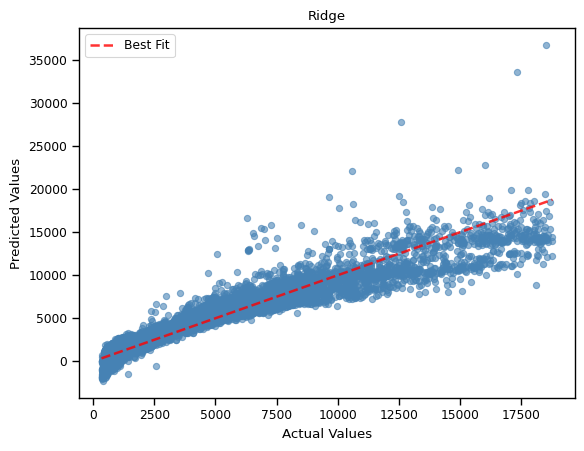

In [138]:
plot_ap(y_test, ridge.predict(X_test), title=get_estimator_name(ridge))

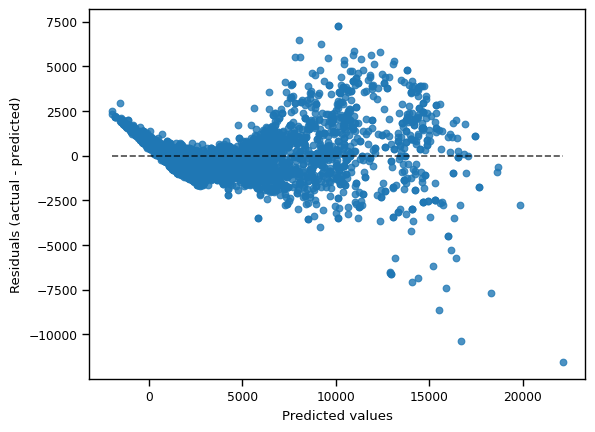

In [198]:
PredictionErrorDisplay.from_estimator(ridge, X_test, y_test, subsample=5000)

In [139]:
model_scores(ridge, X_test, y_test)

{'R-squared': 0.9,
 'Mean Absolute Error': 810.17,
 'Mean Squared Error': 1504090.8,
 'Root Mean Squared Error': 1226.41}

In [140]:
feature_names = ridge[:-1].get_feature_names_out()

In [141]:
ridge_pi = permutation_importance(ridge, X_train, y_train)

Text(0.5, 1.0, 'Feature importance from coefficients')

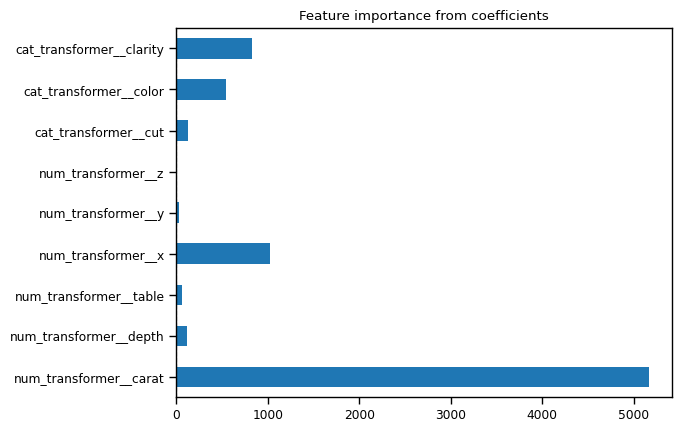

In [142]:
fig, ax = plt.subplots()
pd.Series(np.abs(ridge[-1].coef_), index=ridge[:-1].get_feature_names_out()).plot.barh(ax=ax)
ax.axvline(color="k", linestyle="--", linewidth=0.8)
ax.set_title("Feature importance from coefficients")

In [143]:
ridge_pi

{'importances_mean': array([3.33376208e+00, 2.22677365e-03, 3.78327699e-02, 8.45056831e-02,
        1.65080295e-03, 4.86642083e-04, 1.31789712e-01, 9.91180241e-05,
        1.50710308e-05]),
 'importances_std': array([2.97070810e-02, 8.03365058e-05, 6.27535044e-04, 4.22026742e-04,
        4.40069249e-05, 3.07464407e-05, 1.13819438e-03, 2.28613554e-05,
        1.02484745e-05]),
 'importances': array([[3.32112686e+00, 3.31980272e+00, 3.29587448e+00, 3.38248944e+00,
         3.34951692e+00],
        [2.27999476e-03, 2.13980329e-03, 2.14029131e-03, 2.34674940e-03,
         2.22702951e-03],
        [3.77653375e-02, 3.89273758e-02, 3.71203602e-02, 3.73519485e-02,
         3.79988273e-02],
        [8.41369110e-02, 8.50961749e-02, 8.45273571e-02, 8.48174430e-02,
         8.39505295e-02],
        [1.68366771e-03, 1.68432888e-03, 1.69194557e-03, 1.59552891e-03,
         1.59854367e-03],
        [4.93074481e-04, 4.46778024e-04, 4.57952649e-04, 5.04595376e-04,
         5.30809885e-04],
        [1.3

<Axes: title={'center': 'Permutation Importance'}>

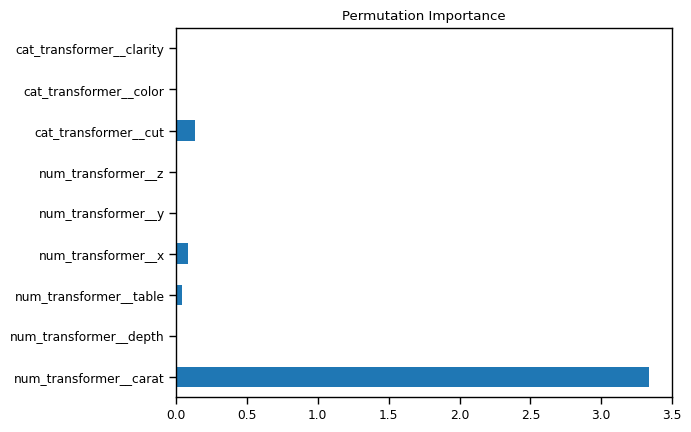

In [144]:
pd.Series(ridge_pi.importances_mean, index=feature_names).plot.barh(title="Permutation Importance")

## **8. Transformed Target (y)**

<Axes: title={'center': 'log(price) distribution'}, xlabel='Log of price', ylabel='Frequency'>

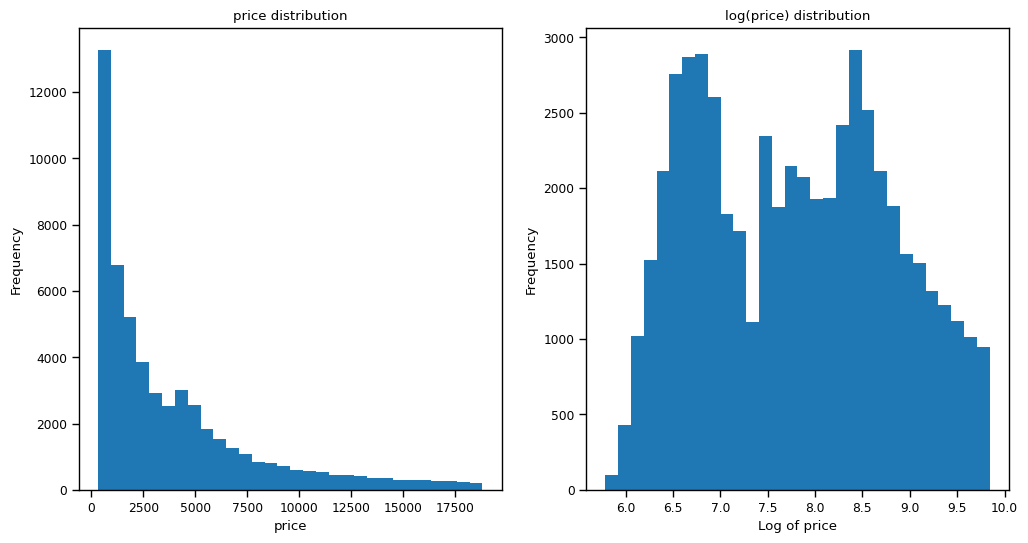

In [145]:
y2 = y.copy()
fig, axs = plt.subplots(ncols=2, figsize = (12, 6))
y2.plot.hist(bins=30, title='price distribution', xlabel='price', ax=axs[0])
np.log(y2).plot.hist(bins=30, xlabel="Log of price", title="log(price) distribution", ax=axs[1])

### Ridge after transformed target

In [146]:
ridge_ttr = make_pipeline(preprocessor, transformed_target(Ridge()))

In [147]:
ridge_ttr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                                              array(['J', 'I', 'H',...], dtype='<U1'),
                                                                                              array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Ridge(),
                                            transformer=QuantileTransformer(output_distribution='normal')))])

In [148]:
ridge_ttr.score(X_test, y_test)

0.9473658282375976

<Axes: title={'center': 'TransformedTarget_Ridge'}, xlabel='Actual Values', ylabel='Predicted Values'>

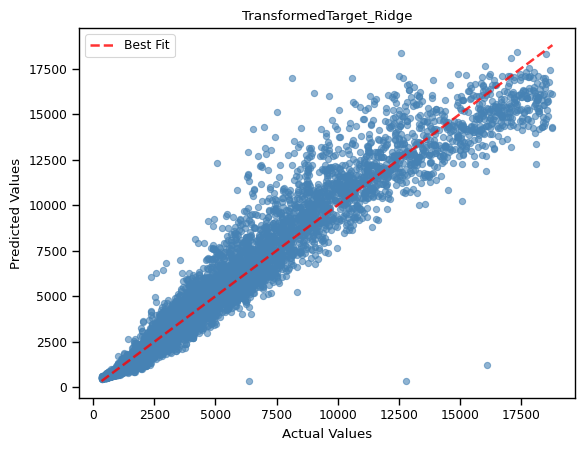

In [149]:
plot_ap(y_test, ridge_ttr.predict(X_test), title=get_estimator_name(ridge_ttr))

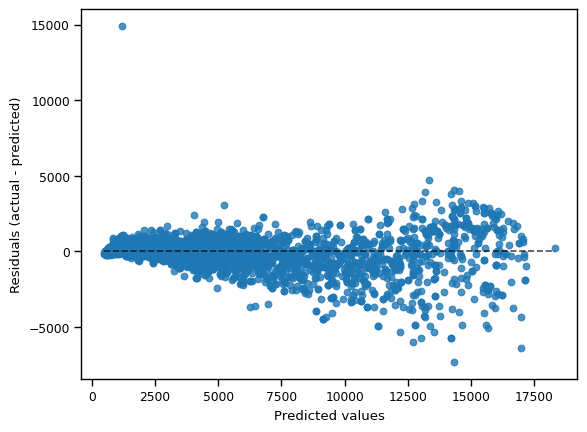

In [197]:
PredictionErrorDisplay.from_estimator(ridge_ttr, X_test, y_test, subsample=5000)

## **9. RandomForestRegressor**

In [150]:
random_forest = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=50))

In [151]:
random_forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                                              array(['J', 'I', 'H', 'G', 'F', 'E', 'D'], dtype='<U1'),
                                                                                              array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=50))])

In [152]:
random_forest.score(X_test, y_test)

0.981444531400375

<Axes: >

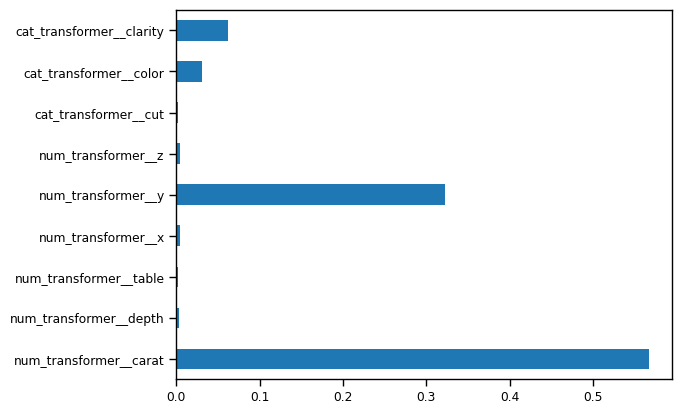

In [153]:
pd.Series(random_forest[-1].feature_importances_, index=feature_names).plot.barh()

In [154]:
random_forest_pi = permutation_importance(random_forest, X_train, y_train)

<Axes: >

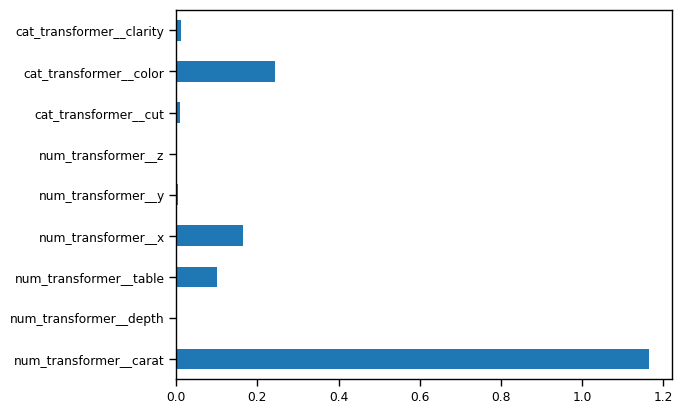

In [155]:
pd.Series(random_forest_pi.importances_mean, index=feature_names).plot.barh()

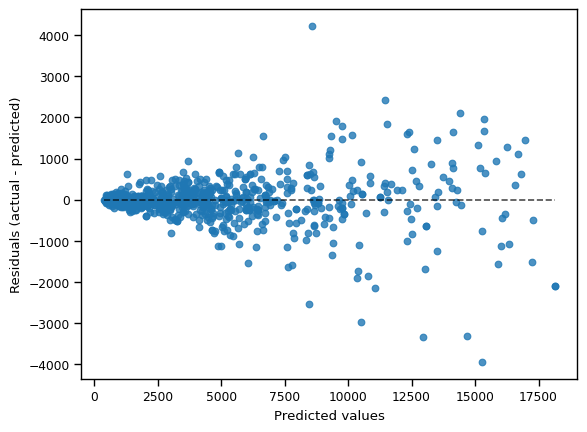

In [192]:
PredictionErrorDisplay.from_estimator(random_forest, X_test, y_test, subsample=1000)

## **10. DecisionTreeRegressor**

In [156]:
decision = make_pipeline(preprocessor, DecisionTreeRegressor(max_depth=20))

In [157]:
decision.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                                              array(['J', 'I', 'H', 'G', 'F', 'E', 'D'], dtype='<U1'),
                                                                                              array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=20))])

In [158]:
decision.score(X_test, y_test)

0.967835690869846

<Axes: >

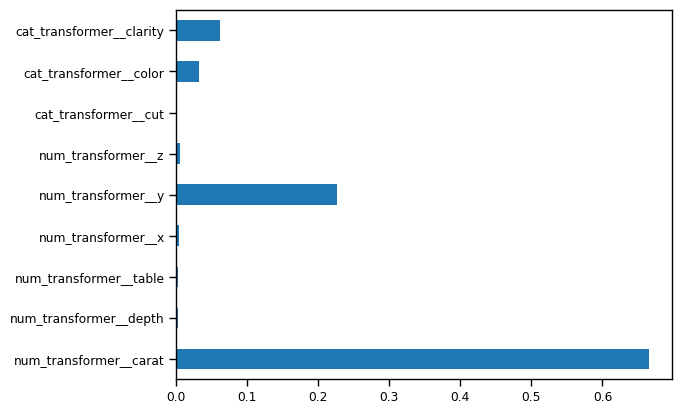

In [201]:
pd.Series(decision[-1].feature_importances_, index=feature_names).plot.barh()

In [159]:
decision_pi = permutation_importance(decision, X_train, y_train)

<Axes: >

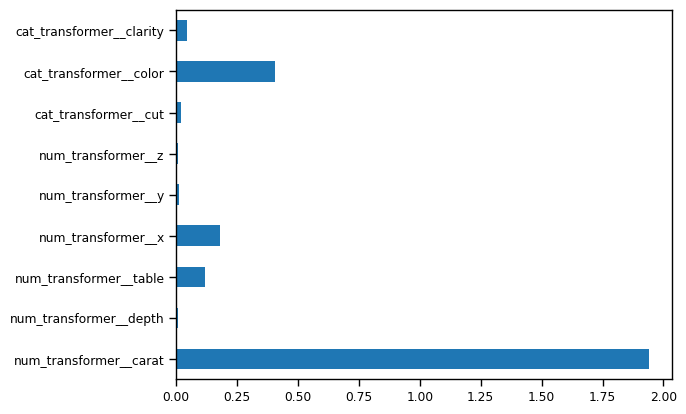

In [160]:
pd.Series(decision_pi.importances_mean, index=feature_names).plot.barh()

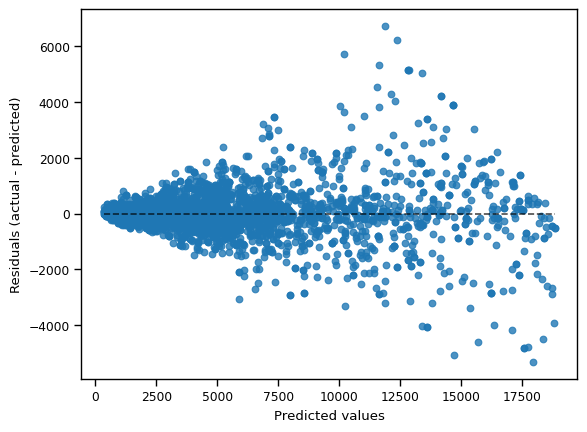

In [196]:
PredictionErrorDisplay.from_estimator(decision, X_test, y_test, subsample=5000)

## **11. RandomForestRegressor after Feature Selection**
As we have seen above, in 9.RandomForestRegressor model feature importance of some of the fetaures is almost zero. But we cannot rely on the feature importance as it is calculated by gini impurity, so we check the model dependencies on each feature through permutation importance.

**1. Feature Importance through Gini Impurity:** By taking gini impurity into account, the model selects carat, y, color and clarity as the important features.


**2. Feature Importance through Permutation Importance:** Using permutation importance, we get features carat, x , table and color are the important features for this model.


There are many ways for feature selection. But for RandomForestRegressor, we can select important features through SequentialFeatureSelector, dropping other unnecessory features to our regressor.

In [206]:
# SequentialFeatureSelector will use DecisionTreeRegressor as baseline estimator to select important features
feature_selector = SequentialFeatureSelector(
    estimator=DecisionTreeRegressor(max_depth=30)
)

In [207]:
forest = make_pipeline(preprocessor, feature_selector, RandomForestRegressor(n_estimators=50))

In [208]:
forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                                              array(['J', 'I', 'H',...
                                                                                              array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=DecisionTreeRegressor(max_depth=30))),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=50))])

In [209]:
forest.score(X_test, y_test)

0.9767000991044553

In [210]:
forest[:-1].get_feature_names_out()

array(['num_transformer__carat', 'num_transformer__y',
       'cat_transformer__color', 'cat_transformer__clarity'], dtype=object)

In [211]:
model_scores(forest, X_test, y_test)

{'R-squared': 0.98,
 'Mean Absolute Error': 315.09,
 'Mean Squared Error': 360876.36,
 'Root Mean Squared Error': 600.73}

<Axes: xlabel='Actual Values', ylabel='Predicted Values'>

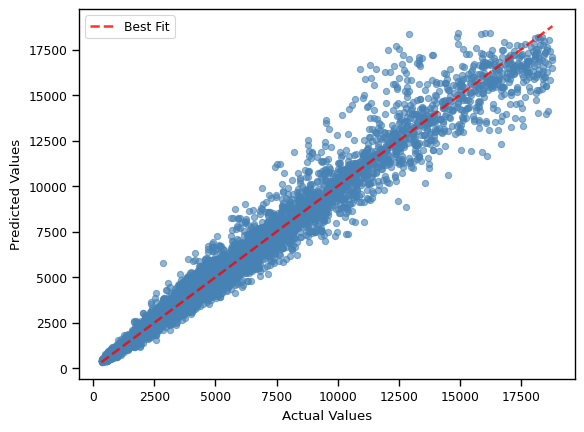

In [212]:
plot_ap(y_test, forest.predict(X_test))

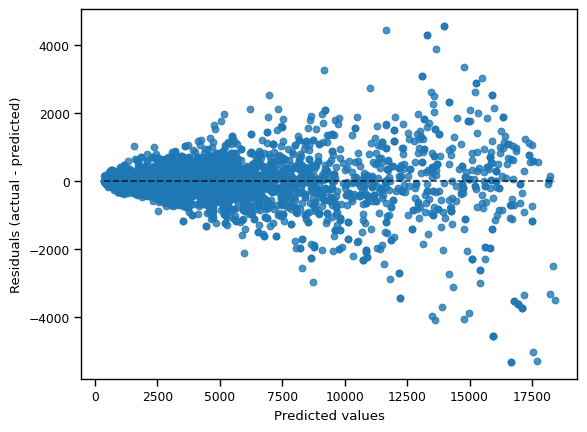

In [213]:
PredictionErrorDisplay.from_estimator(forest, X_test, y_test, subsample=5000)

In [214]:
forest[-1].feature_importances_

array([0.53479627, 0.37005667, 0.03306042, 0.06208664])

<Axes: >

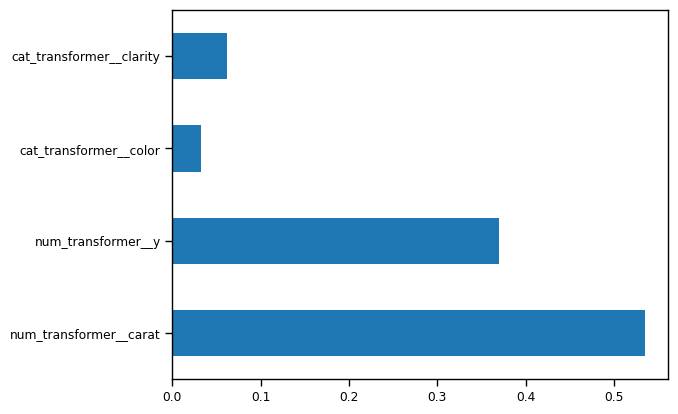

In [215]:
pd.Series(forest[-1].feature_importances_, index=forest[:-1].get_feature_names_out()).plot.barh()

## **12. K-Nearest Neighbors Regressor**

In [177]:
knn_d = make_pipeline(preprocessor, KNeighborsRegressor(weights="distance"))

In [178]:
knn_d.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                                              array(['J', 'I', 'H', 'G', 'F', 'E', 'D'], dtype='<U1'),
                                                                                              array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])),
                ('kneighborsregressor',
                 KNeighborsRegressor(weights='distance'))])

In [179]:
knn_d.score(X_test, y_test)

0.9711048528271441

In [180]:
model_scores(knn_d, X_test, y_test)

{'R-squared': 0.97,
 'Mean Absolute Error': 352.8,
 'Mean Squared Error': 447537.34,
 'Root Mean Squared Error': 668.98}

<Axes: xlabel='Actual Values', ylabel='Predicted Values'>

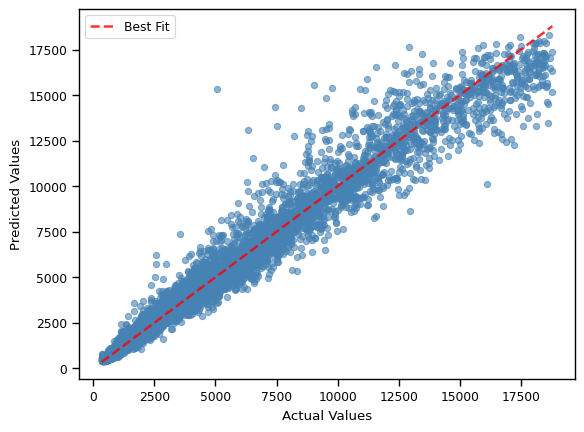

In [181]:
plot_ap(y_test, knn_d.predict(X_test))

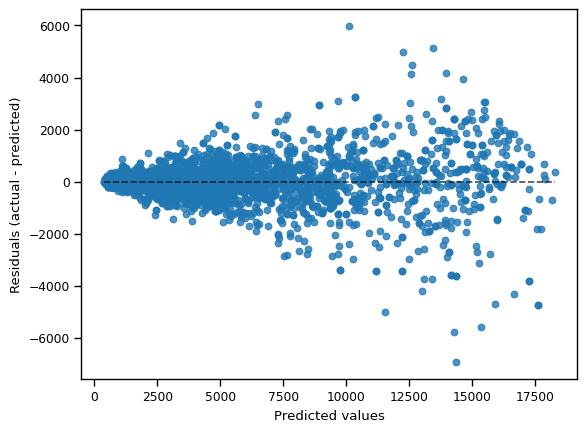

In [199]:
PredictionErrorDisplay.from_estimator(knn_d, X_test, y_test, subsample=5000)

In [182]:
knn_u = make_pipeline(preprocessor, KNeighborsRegressor())

In [183]:
knn_u.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aafc70>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[array(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='<U9'),
                                                                                              array(['J', 'I', 'H', 'G', 'F', 'E', 'D'], dtype='<U1'),
                                                                                              array(['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
      dtype='<U4')])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca760aaca60>)])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [184]:
knn_u.score(X_test, y_test)

0.9689198215501801

In [185]:
model_scores(knn_u, X_test, y_test)

{'R-squared': 0.97,
 'Mean Absolute Error': 371.2,
 'Mean Squared Error': 481379.81,
 'Root Mean Squared Error': 693.82}

<Axes: xlabel='Actual Values', ylabel='Predicted Values'>

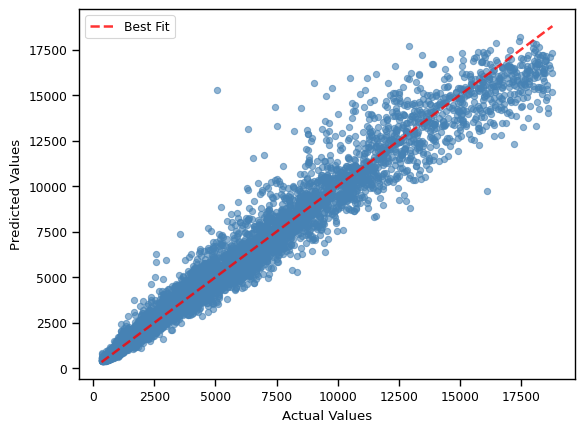

In [186]:
plot_ap(y_test, knn_u.predict(X_test))

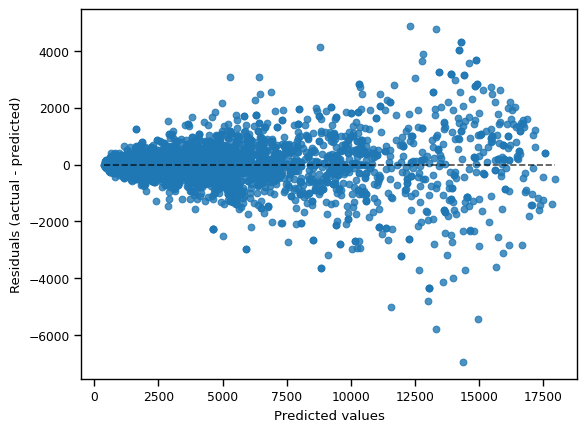

In [200]:
PredictionErrorDisplay.from_estimator(knn_u, X_test, y_test, subsample=5000)